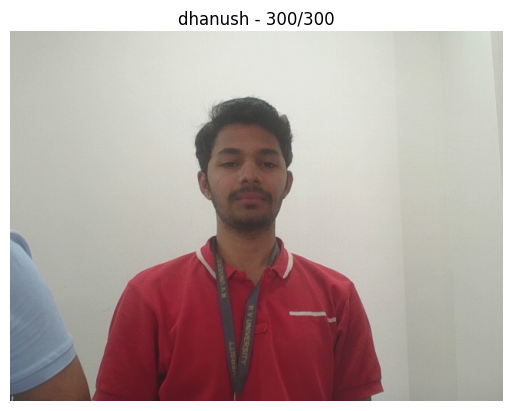

✅ Done collecting 300 images for 'dhanush' saved in images\dhanush

👋 Exiting.


In [8]:
import os
import sys
import time
from pathlib import Path
import cv2
import numpy as np
from deepface import DeepFace
import matplotlib.pyplot as plt
from IPython.display import clear_output

# --- CONFIG ---
TARGET_COUNT = 300
DETECTOR_BACKEND = "opencv"
DEBUG = False
# ---------------

def show_frame_inline(frame, text):
    """Display camera frame inline (for environments without cv2.imshow)."""
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    clear_output(wait=True)
    plt.imshow(frame_rgb)
    plt.title(text)
    plt.axis('off')
    plt.show(block=False)
    plt.pause(0.01)

def collect_faces(name):
    OUT_DIR = Path("images") / name
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    if not cap.isOpened():
        print("❌ Failed to open camera.")
        sys.exit(1)

    count = len(list(OUT_DIR.glob("*.jpg")))
    print(f"📸 Starting for '{name}' — {count}/{TARGET_COUNT} images")

    try:
        while count < TARGET_COUNT:
            ret, frame = cap.read()
            if not ret:
                print("⚠️ Camera read failed, retrying...")
                time.sleep(0.5)
                continue

            try:
                faces = DeepFace.extract_faces(
                    img_path=frame,
                    detector_backend=DETECTOR_BACKEND,
                    enforce_detection=True,
                    align=True,
                    expand_percentage=20
                )
            except Exception as ex:
                if DEBUG:
                    print("DeepFace error:", ex)
                faces = []

            for face_data in faces:
                face_img = face_data.get('face') if isinstance(face_data, dict) else face_data
                if isinstance(face_img, np.ndarray) and face_img.size > 0:
                    if np.issubdtype(face_img.dtype, np.floating):
                        face_img = (face_img * 255).clip(0, 255).astype(np.uint8)

                    save_path = OUT_DIR / f"{name}_{count+1:04d}.jpg"
                    if cv2.imwrite(str(save_path), face_img):
                        count += 1
                        print(f"✅ {name}: saved {count}/{TARGET_COUNT}")
                    if count >= TARGET_COUNT:
                        break

            # Inline display (instead of cv2.imshow)
            show_frame_inline(frame, f"{name} - {count}/{TARGET_COUNT}")

    except KeyboardInterrupt:
        print("🛑 Stopped manually.")
    finally:
        cap.release()
        print(f"✅ Done collecting {count} images for '{name}' saved in {OUT_DIR}\n")

# --- MAIN LOOP ---
while True:
    user_name = input("Enter user name (or 'exit' to quit): ").strip()
    if user_name.lower() == 'exit':
        print("👋 Exiting.")
        break
    if not user_name:
        print("⚠️ Name cannot be empty.")
        continue
    collect_faces(user_name)
